In [1]:
from lib.clip_utils import CLIPModel
from gen.clip_guided import generate_w_clip
from gen.rsp_sampling import rsp_sampling
from lib.utils import set_seed, load_model
from PIL import Image
from matplotlib import pyplot as plt


model_name = 'llava_v1_5'
model_type = '7b'

# model_name = 'mplug_owl2'
# model_type = 'llama2-7b'

# model_name = 'blip2_vicuna_instruct'
# model_type = 'vicuna7b'

device = 'cuda:0'



In [2]:
print('begin loading model')
model, vis_processor, tokenizer = load_model(model_name=model_name, model_type=model_type, device=device)
model.eval()
print('end loading model')

clip_scorer = CLIPModel(device=device)

begin loading model


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

end loading model


In [3]:
if model_name == 'llava_v1_5':
    text = "<image>\nDescribe this image in detail."
elif model_name == 'blip2_vicuna_instruct':
    text = "Describe this image in detail."
elif model_name == 'mplug_owl2':
    text = "<|image|>Describe this image in detail.\n"

In [4]:
args = {
    'model_name': model_name,
    'model_type': model_type,
    'algo_name': 'sentence_clip',
    'sampling_params': {
        'temperature': 0.2,
        'top_p': 1,
        'top_k': 5, # added
        'num_beams': 1,
        'do_sample': True,
        'num_return_sequences': 3,
        'max_new_tokens': 500,
    },
    'scoring': {
        'alpha': 0.01, # prob
        'beta': 1, # clip
        'prob_type': 'lennorm_sum_log',
        'max_cand_num': 3
    }
}


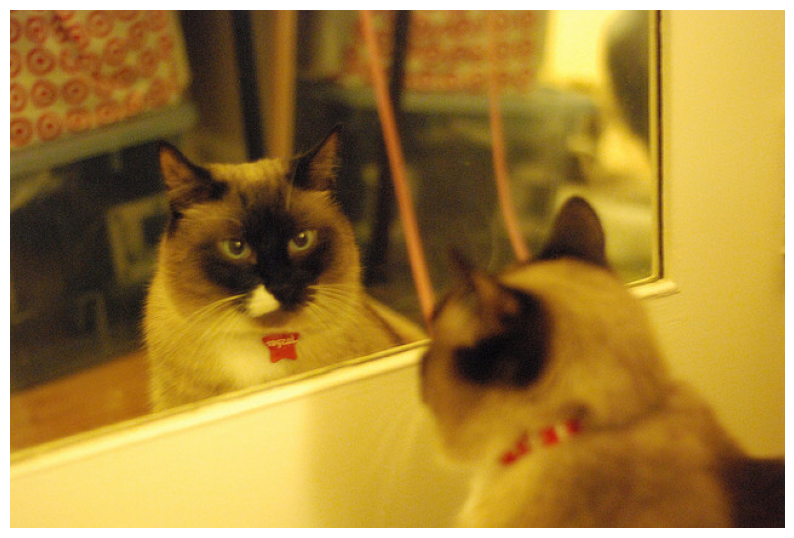

Top-k Sampling:
The image features a cat sitting in front of a mirror, looking at its reflection. The cat is positioned on the left side of the mirror, and its reflection can be seen on the right side. The cat appears to be curious about its own image.

In the background, there is a chair located near the right edge of the image. Additionally, there is a bottle placed on the left side of the scene, slightly above the cat's reflection.
--------------------------------------------------
(Ours) CLIP-Guided Decoding:
The image features a cat sitting in front of a mirror, looking at its reflection. The cat appears to be curious about its own image, as it gazes intently at the mirror. The reflection of the cat is visible in the mirror, creating a sense of depth and interest in the scene.


In [19]:
# image_id = '480720'
image_id = '075600'
image_path = './assets/COCO_val2014_000000{}.jpg'.format(image_id)
image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

set_seed(0)
all_generated_str = rsp_sampling(model, tokenizer, vis_processor, text, image, device=device, verbose=False, final_res_num=1, 
                                 args={**args, 'sampling_params': {**args['sampling_params'], 'num_return_sequences': 1}})
print('Top-k Sampling:')
print(all_generated_str[0])

set_seed(0)
all_generated_str = generate_w_clip(model, tokenizer, vis_processor, text, image, device=device, verbose=False, final_res_num=1, args=args,
                                                                 return_max_probs=True, return_clip_scores=True, clip_scorer=clip_scorer)
print('-'*50)
print('(Ours) CLIP-Guided Decoding:')
print(all_generated_str[0])